# Data Wrangling

In this notebook we clean and tidy our data, and save analysis and modeling for [another notebook](./analysis-and-modeling.ipynb)

<div class="toc"><ul class="toc-item"><li><span><a href="#Gather-and-Assess" data-toc-modified-id="Gather-and-Assess-1">Gather and Assess</a></span></li><li><span><a href="#Clean-and-Tidy" data-toc-modified-id="Clean-and-Tidy-2">Clean and Tidy</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#listings-dataset" data-toc-modified-id="listings-dataset-2.0.1"><code>listings</code> dataset</a></span><ul class="toc-item"><li><span><a href="#Drop-rows/columns" data-toc-modified-id="Drop-rows/columns-2.0.1.1">Drop rows/columns</a></span></li><li><span><a href="#Enforce-dtypes" data-toc-modified-id="Enforce-dtypes-2.0.1.2">Enforce dtypes</a></span></li><li><span><a href="#Missing-Values" data-toc-modified-id="Missing-Values-2.0.1.3">Missing Values</a></span></li><li><span><a href="#Downcast-dtypes" data-toc-modified-id="Downcast-dtypes-2.0.1.4">Downcast dtypes</a></span></li></ul></li><li><span><a href="#calendar-dataset" data-toc-modified-id="calendar-dataset-2.0.2"><code>calendar</code> dataset</a></span><ul class="toc-item"><li><span><a href="#Drop-rows/columns" data-toc-modified-id="Drop-rows/columns-2.0.2.1">Drop rows/columns</a></span></li><li><span><a href="#Enforce-dtypes" data-toc-modified-id="Enforce-dtypes-2.0.2.2">Enforce dtypes</a></span></li><li><span><a href="#Missing-Values" data-toc-modified-id="Missing-Values-2.0.2.3">Missing Values</a></span></li><li><span><a href="#Synchronize-date" data-toc-modified-id="Synchronize-date-2.0.2.4">Synchronize <code>date</code></a></span></li></ul></li></ul></li><li><span><a href="#Create-amenities-features." data-toc-modified-id="Create-amenities-features.-2.1">Create amenities features.</a></span></li><li><span><a href="#Currency-conversion" data-toc-modified-id="Currency-conversion-2.2">Currency conversion</a></span></li><li><span><a href="#Save-cleaned-datasets" data-toc-modified-id="Save-cleaned-datasets-2.3">Save cleaned datasets</a></span></li></ul></li></ul></div>

In [73]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style('darkgrid')
import re
import os

from collections import defaultdict
from pandas.api.types import CategoricalDtype
from functools import partial
from matplotlib.axes._axes import _log as matplotlib_axes_logger

# settings
pd.set_option('display.max_columns', None)
matplotlib_axes_logger.setLevel('ERROR')

## Gather and Assess 

The data we're using was compiled by [InsideAirbnb](http://insideairbnb.com/) from information made publicly available on [Airbnb](http://airbnb.com). Some interesting disclaimers about the data can be found at the [about page](http://insideairbnb.com/about.html) as well as more about Inside Airbnb's model for estimating occupancy rate. You can find datasets for a very large number of major cities worldwide [here](http://insideairbnb.com/about.html).

For each city, InsideAirbnb provides data sets which are updated roughly monthly. Let's collect the most recent available for Vancouver, Seattle, and Portland

In [79]:
# download and unzip data
!sh getdata.sh

mkdir: ./data/: File exists
--2020-03-05 23:29:59--  http://data.insideairbnb.com/united-states/or/portland/2020-02-13/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.144.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.144.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6002650 (5.7M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]   5.72M  5.00MB/s    in 1.1s    

2020-03-05 23:30:00 (5.00 MB/s) - ‘listings.csv.gz’ saved [6002650/6002650]

--2020-03-05 23:30:01--  http://data.insideairbnb.com/united-states/or/portland/2020-02-13/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.144.50
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.144.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5449097 (5.2M) [application/x-gzip]
Saving to: ‘calendar.csv.gz’

calendar.csv.gz   

After unzipping and renaming, we have 3 data files for each city.


|File Name               | Description                                |
|------------------------|--------------------------------------------|
| listings.csv           | Detailed Listings data                     |
| calendar.csv           | Detailed Calendar data for listings        |
| neighbourhoods.geojson | GeoJSON file of neighbourhoods of the city.|

These can all be found in the `/data` directory.

In [3]:
def load_dfs(file_prefixes, city_names, files_path):
    """Load all but .geojson data files for each city into nested dict of dataframes."""
    dfs = defaultdict(dict)

    for file_prefix in file_prefixes:
        for city_name in city_names:
            file_path = files_path + city_name + '_' + file_prefix + '.csv'
            dfs[file_prefix][city_name] = pd.read_csv(file_path)

    return dfs

file_prefixes = ['listings', 'calendar']
city_names = ['seattle', 'portland', 'vancouver']
files_path = 'data/'
dfs = load_dfs(file_prefixes, city_names, files_path)

Some of the questions we're interested in involve comparisons between the three cities, so we'll merge the corresponding dataframes for each city into a single large dataframe.

In [4]:
def merge_dfs(dfs, file_prefixes, city_names):
    """Merge dataframes for each kind of data file."""
    merged_dfs = defaultdict(list)
    
    for file_prefix in file_prefixes:
        dfs_list = [dfs[file_prefix][city_name] for city_name in city_names]
        merged_dfs[file_prefix] = pd.concat(dfs_list, keys=city_names, names=['city'])
        try:
            merged_dfs[file_prefix].drop(columns=['city'], inplace=True)
        except:
            pass

    return merged_dfs
        
dfs = merge_dfs(dfs, file_prefixes, city_names)

The main dataset we'll be relying on is the `listings` dataset.

In [5]:
listings_df = dfs['listings']
listings_df.head(3)

id                        listing_url       scrape_id  \
city                                                                 
seattle 0  2318  https://www.airbnb.com/rooms/2318  20200222045957   
        1  6606  https://www.airbnb.com/rooms/6606  20200222045957   
        2  9419  https://www.airbnb.com/rooms/9419  20200222045957   

          last_scraped                                               name  \
city                                                                        
seattle 0   2020-02-22  Casa Madrona - Urban Oasis 1 block from the park!   
        1   2020-02-22                Fab, private seattle urban cottage!   
        2   2020-02-22                Glorious sun room w/ memory foambed   

                                                     summary  \
city                                                           
seattle 0  Gorgeous, architect remodeled, Dutch Colonial ...   
        1  This tiny cottage is only 15x10, but it has ev...   
        2  This beautiful double room features a magical ...   

                                                       space  \
city                                                           
seattle 0  This beautiful, gracious home has been complet...   
        1  Soo centrally located, this is a little house ...   
        2  Our new Sunny space has a private room from th...   

                                                 description  \
city                                                           
seattle 0  Gorgeous, architect remodeled, Dutch Colonial ...   
        1  This tiny cottage is only 15x10, but it has ev...   
        2  This beautiful double room features a magical ...   

          experiences_offered  \
city                            
seattle 0                none   
        1                none   
        2                none   

                                       neighborhood_overview  \
city                                                           
seattle 0  Madrona is a hidden gem of a neighborhood. It ...   
        1  A peaceful yet highly accessible neighborhood,...   
        2  Lots of restaurants (see our guide book) bars,...   

                                                       notes  \
city                                                           
seattle 0  We adhere to a 10pm -9am quiet hour schedule, ...   
        1  Check in is at three, if you'd like a snack or...   
        2  This area is an arts district,you will see all...   

                                                     transit  \
city                                                           
seattle 0                                                NaN   
        1                                                NaN   
        2  Car 2 go is in this neigborhood Bus is across ...   

                                                      access  \
city                                                           
seattle 0           Guests can access any part of the house.   
        1                                                NaN   
        2  24 /7 access kitchen, bathroom and community s...   

                                                 interaction  \
city                                                           
seattle 0  We are a family who live next door and are ava...   
        1  I often escape to kingston and my place on the...   
        2  I have a hands on warm approach to guests but ...   

                                                 house_rules  thumbnail_url  \
city                                                                          
seattle 0                                                NaN            NaN   
        1  Please treat the cottage as if it were your ow...            NaN   
        2  No drugs,no smoking inside *outside in front o...            NaN   

           medium_url                                        picture_url  \
city                                                                  

In [6]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18429 entries, ('seattle', 0) to ('vancouver', 6205)
Columns: 105 entries, id to reviews_per_month
dtypes: float64(21), int64(21), object(63)
memory usage: 14.9+ MB


There are 19997 total listings, with 105 columns. Columns are well named and descriptive enough to make sense of the variables they correspond to. We note that lot of these variables are long text strings. This dataset provides a lot of interesting opportunities for natural language processing.

We'll also be making use of the `calendar` dataset

In [7]:
calendar_df = dfs['calendar']
calendar_df.head(3)

listing_id        date available   price adjusted_price  \
city                                                                 
seattle 0      788146  2020-02-22         f  $68.00         $68.00   
        1      340706  2020-02-22         t  $90.00         $90.00   
        2      340706  2020-02-23         t  $90.00         $90.00   

           minimum_nights  maximum_nights  
city                                       
seattle 0            30.0           180.0  
        1             2.0            60.0  
        2             2.0            60.0

In [8]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6726585 entries, ('seattle', 0) to ('vancouver', 2265189)
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 412.3+ MB


There are 7298905 calendar entries, with 7 variables describing them. Again column names are descriptive.

## Clean and Tidy


#### `listings` dataset

##### Drop rows/columns

First we check for duplicates

In [9]:
# number of duplicate rows
num_dups = listings_df.duplicated().sum()
num_dups

0

Next we'll looks at rows or columns containing a lot of missing values. We'll choose a lower threshold of 25% missing values

In [10]:
def prop_missing_vals_df(df, axis=0, threshold=0.25, ascending=False):
    """Get missing values in df by proportion above threshold along axis."""
    prop = df.isna().sum(axis=axis).sort_values(ascending=ascending)
    prop = prop/df.shape[axis]
    prop.name = 'prop_miss_vals'
    return pd.DataFrame(prop[prop > threshold])

In [11]:
# rows with high proportion of missing values in listings df
prop_missing_vals_df(listings_df, axis=1, threshold=0.25)

prop_miss_vals
city                          
vancouver 3263        0.323810
          5791        0.323810
          6006        0.323810
          5564        0.323810
seattle   7021        0.323810
...                        ...
portland  4295        0.257143
seattle   764         0.257143
portland  3894        0.257143
vancouver 5921        0.257143
seattle   2987        0.257143

[326 rows x 1 columns]

There are quite 475 rows missing more than 25% of values, but no rows are missing 100% of values. 
We'll address these missing values by column instead.

In [12]:
# columns with high proportion of missing values in listings df
prop_missing_vals_df(listings_df, axis=0, threshold=0.25)

,prop_miss_vals
xl_picture_url,1.000000
medium_url,1.000000
thumbnail_url,1.000000
square_feet,0.963536
monthly_price,0.906560
weekly_price,0.893266
neighbourhood_group_cleansed,0.590645
notes,0.414618
access,0.340713
host_about,0.291551


Inspecting each of these more carefully, we'll drop all of these columns for the following reasons:

- `interaction`, `neighbourhood_overview`, `transit`, `host_about`, `access`, `notes`: These are all text fields which would require somewhat sophisticated NLP.
- `neighbourhood_group_cleansed`: Large proportion of missing values and we can get more precise information from `neighborhood`
- `weekly_price`, `monthly_price`: Large proportion of missing values and we're more interested in (daily) `price`
- `square_feet`, `thumbnail_url`, `xl_picture_url`, `medium_url`, `host_acceptance_rate`: Too high percentage of missing values to be useful.
- `license`: Irrelevant to our analysis

In [13]:
# start collecting columns to drop from listings df
drop_cols = set(prop_missing_vals_df(listings_df, axis=0).index)

There are quite a few more columns we can drop. To make this easier to manage, lets display columns of `listings` in alphabetical order:

In [14]:
# alphabetize columns besides those selected for dropping and inspect
alph_cols = list(set(listings_df.columns).difference(drop_cols))
alph_cols.sort()
listings_df[alph_cols].head(1)

,,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,state,street,summary,zipcode
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seattle,0,9,"{Internet,Wifi,Kitchen,""Free parking on premis...",6,65,36,65,2.5,Real Bed,4.0,4.0,2,2,0,0,2020-02-22,4 weeks ago,strict_14_with_grace_period,$250.00,United States,US,"Gorgeous, architect remodeled, Dutch Colonial ...",none,$25.00,2008-09-15,8,t,92%,t,2536,f,t,2.0,"Seattle, Washington, United States",Megan,Minor,https://a0.muscache.com/im/pictures/user/016a1...,100%,within an hour,2008-08-26,https://a0.muscache.com/im/pictures/user/016a1...,2.0,https://www.airbnb.com/users/show/2536,"['email', 'phone', 'reviews', 'jumio', 'offlin...",NaN,2318,f,We are a family who live next door and are ava...,f,t,"{WASHINGTON,"" Seattle"","" WA""}",2020-02-01,2020-02-22,47.61082,STR-OPLI-19-002837,https://www.airbnb.com/rooms/2318,-122.29082,Seattle,1000,7,1000,1000.0,1000,7,7,7.0,Casa Madrona - Urban Oasis 1 block from the park!,Madrona is a hidden gem of a neighborhood. It ...,Madrona,Madrona,32,11,https://a0.muscache.com/im/pictures/02973ad3-a...,$296.00,House,f,f,t,10.0,10.0,10.0,10.0,10.0,100.0,10.0,0.23,Entire home/apt,20200222045957,$500.00,"Seattle, WA","This beautiful, gracious home has been complet...",WA,"Seattle, WA, United States","Gorgeous, architect remodeled, Dutch Colonial ...",98122


We'll also drop the following columns for the following reasons:

- `description`, `house_rules`, `name`, `space`, `summary`: long string text columns that could be useful but would require some NLP (which is beyond this scope of this project). 
- `calendar_updated`, `host_location`, `host_name`, `host_neighbourhood`, `host_picture_url`,  `host_thumbnail_url`, `host_url`, `host_verifications`, `is_location_exact`, `jurisdiction_names`, `listing_url`, `market`, `name`, `picture_url`, `scrape_id`: Irrelevant for our analysis
- `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights`, `minimum_minimum_nights`,  `minimum_nights_avg_ntm`, `maximum_nights_avg_ntm` - Difficult to interpret and possibly less relevant (given presence of `minimum_nights`, `maximum_nights`)
- `last_scraped`, `calendar_last_scraped`, `country`, `country_code`, `experiences_offered`, `has_availability`: All have the same value for this dataset
- `host_has_profile_pic`: Extreme class imbalance (99.8% vs. 0.2%).
- `smart_location`: Highly imbalanced and superceded by other variables.
- `street`: Doesn't even contain street information!
- `state`: Redundant (given city information) and not relevant
- `zipcode`: Superceded by other more useful geographic variables (`neighbourhood`, `latitude`, `longitude`)
- `host_listings_count`, `host_total_listings_count`, `neighbourhood`: Appears to be from original AirBnB data - superceded by other variables created by Inside AirBnB (names beginning    with prefix `calculated_`)
- `number_of_reviews_ltm` - meaning unclear

That was a lot of detailed justification, but it can be helpful to be explicit and clear about reasons for ignoring information.

In [15]:
# add remaining columns to drop and drop
more_drop_cols = {'description', 'house_rules', 'name', 'space', 'summary', 'calendar_updated', 'host_location',
                  'host_name', 'host_neighbourhood', 'host_picture_url', 'host_thumbnail_url', 'host_url', 
                  'host_verifications', 'is_location_exact', 'jurisdiction_names', 'listing_url', 'market', 
                  'name', 'picture_url', 'scrape_id', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                  'maximum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights_avg_ntm',
                  'maximum_nights_avg_ntm', 'last_scraped', 'calendar_last_scraped', 'country', 'country_code', 
                  'experiences_offered', 'has_availability', 'host_has_profile_pic', 'smart_location', 'street', 
                  'state', 'host_listings_count', 'host_total_listings_count', 'neighbourhood', 'zipcode', 
                  'number_of_reviews_ltm'}
drop_cols = drop_cols.union(more_drop_cols)
listings_df = listings_df.drop(columns=drop_cols)

In [16]:
def alphabetize_cols(df, first_col='id'):
    """Alphabetize columns."""
    df_cp = df.copy()
    alph_cols = list(df_cp.columns.sort_values())
    alph_cols.remove(first_col)
    alph_cols = [first_col] + alph_cols
    df_cp = df_cp[alph_cols]
    return df_cp

listings_df = alphabetize_cols(listings_df)

##### Enforce dtypes

Now that we're left with the variables we're interested in, we'll see if any need processing before we deal with missing values and setting dtypes

In [17]:
listings_df.select_dtypes('int64').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18429 entries, ('seattle', 0) to ('vancouver', 6205)
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   id                                            18429 non-null  int64
 1   accommodates                                  18429 non-null  int64
 2   availability_30                               18429 non-null  int64
 3   availability_365                              18429 non-null  int64
 4   availability_60                               18429 non-null  int64
 5   availability_90                               18429 non-null  int64
 6   calculated_host_listings_count                18429 non-null  int64
 7   calculated_host_listings_count_entire_homes   18429 non-null  int64
 8   calculated_host_listings_count_private_rooms  18429 non-null  int64
 9   calculated_host_listings_count_shared_rooms   18429 non-

All of the variables with integer type look good. Also since `np.nan` is a float, we can conclude all these variables have no missing values

In [18]:
listings_df.select_dtypes('float64').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18429 entries, ('seattle', 0) to ('vancouver', 6205)
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bathrooms                    18424 non-null  float64
 1   bedrooms                     18409 non-null  float64
 2   beds                         18383 non-null  float64
 3   latitude                     18429 non-null  float64
 4   longitude                    18429 non-null  float64
 5   review_scores_accuracy       15990 non-null  float64
 6   review_scores_checkin        15989 non-null  float64
 7   review_scores_cleanliness    15990 non-null  float64
 8   review_scores_communication  15993 non-null  float64
 9   review_scores_location       15990 non-null  float64
 10  review_scores_rating         15999 non-null  float64
 11  review_scores_value          15991 non-null  float64
 12  reviews_per_month            16089 non-null  fl

All of these variables are indeed numerical. Some of them could be converted to ints -- this may speed computations and reduce the chance of rounding errors. Since `np.nan` is a float however, we'll wait until after we handle missing values. Let's look at which floats can be safely converted to ints.

In [19]:
def can_conv_to_int(list_float_vars):
    """Check which float values can be converted to int without rounding."""
    res = (np.abs(np.floor(list_float_vars) - list_float_vars) > 0).any()
    return ~ res

In [20]:
# dictionary for tracking col dtype conversions
conv_dtypes = defaultdict(set)
# see which float columns can be safely converted to int
conv_to_int = can_conv_to_int(listings_df.select_dtypes('float64').dropna())
conv_to_int_cols = set(conv_to_int[conv_to_int.T].index)
conv_dtypes['int'] = conv_to_int_cols
conv_dtypes['int']

{'bedrooms',
 'beds',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value'}

So we can safely convert all but `reviews_per_month`, `longitude`, `latitude`, and `bathrooms` to integer type (after we've dealt with missing values)

Finally let's look at object variables

In [21]:
listings_df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18429 entries, ('seattle', 0) to ('vancouver', 6205)
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   amenities                         18429 non-null  object
 1   bed_type                          18429 non-null  object
 2   cancellation_policy               18429 non-null  object
 3   cleaning_fee                      17148 non-null  object
 4   extra_people                      18429 non-null  object
 5   first_review                      16089 non-null  object
 6   host_acceptance_rate              17008 non-null  object
 7   host_identity_verified            18428 non-null  object
 8   host_is_superhost                 18428 non-null  object
 9   host_response_rate                15535 non-null  object
 10  host_response_time                15535 non-null  object
 11  host_since                        18428 non-null  obj

In [22]:
listings_df.select_dtypes('object').head(1)

,,amenities,bed_type,cancellation_policy,cleaning_fee,extra_people,first_review,host_acceptance_rate,host_identity_verified,host_is_superhost,host_response_rate,host_response_time,host_since,instant_bookable,interaction,is_business_travel_ready,last_review,license,neighborhood_overview,neighbourhood_cleansed,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,room_type,security_deposit
city,,,,,,,,,,,,,,,,,,,,,,,,,,,
seattle,0,"{Internet,Wifi,Kitchen,""Free parking on premis...",Real Bed,strict_14_with_grace_period,$250.00,$25.00,2008-09-15,92%,f,t,100%,within an hour,2008-08-26,f,We are a family who live next door and are ava...,f,2020-02-01,STR-OPLI-19-002837,Madrona is a hidden gem of a neighborhood. It ...,Madrona,$296.00,House,f,f,t,Entire home/apt,$500.00


Some of these variables can be converted to other appropriate types, without additional processing. We're careful not to cast to boolean dtype with missing data since pandas will automatically convert `np.nan` to `True`

In [23]:
# non-ordered categorical variables
conv_dtypes['categorical'] = {'host_identity_verified', 'host_is_superhost', 'instant_bookable', 
                              'is_business_travel_ready', 'neighbourhood_cleansed', 'property_type', 
                              'require_guest_phone_verification', 'require_guest_profile_picture', 
                              'requires_license'}
conv_dtypes['datetime'] = {'first_review', 'host_since', 'last_review'}

listings_df.loc[:, conv_dtypes['categorical']] = listings_df[conv_dtypes[
                                                 'categorical']].astype('category')
listings_df.loc[:, conv_dtypes['datetime']] = listings_df[conv_dtypes['datetime']]\
                                           .astype('datetime64')

We also have a some categorical data types with natural orderings, since there's a natural way of assigning a price value to them.

In [24]:
def set_ord_cat_dtypes(listings_df, conv_dtypes, ord_cat_cols):
    """Set ordered categorical columns dtypes."""
    listings_df_cp = listings_df.copy()
    for (col, ordering) in conv_dtypes['ordered_categorical'].items():
        dtype = CategoricalDtype(categories=ordering, ordered=True)
        listings_df_cp[col] = listings_df_cp[col].astype(dtype)
    return listings_df_cp

In [25]:
# ordered categorical variables
ord_cat_cols = ['bed_type', 'cancellation_policy', 'host_response_time', 'room_type']
conv_dtypes['ordered_categorical'] = {col:None for col in ord_cat_cols}
conv_dtypes['ordered_categorical']['bed_type'] = ['Couch', 'Airbed', 'Pull-out Sofa', 
                                                  'Futon', 'Real Bed']
conv_dtypes['ordered_categorical']['cancellation_policy'] = ['super_strict_60', 
                                                             'super_strict_30', 
                                                             'strict', 
                                                             'strict_14_with_grace_period', 
                                                             'moderate', 'flexible']
conv_dtypes['ordered_categorical']['host_response_time'] = ['within an hour', 
                                                            'within a few hours', 
                                                            'within a day', 
                                                            'a few days of more']
conv_dtypes['ordered_categorical']['room_type'] = ['Shared room', 'Hotel room', 
                                                   'Private room', 'Entire home/apt']
listings_df = set_ord_cat_dtypes(listings_df, conv_dtypes, ord_cat_cols)

Finally, some of the object variables need to be processed. Some can be easily converted to floats -- in this case, it doesn't matter if `np.nan` is present or not.

In [26]:
def conv_to_float(entry):
    """Float conversion helper."""
    try:
        return entry.replace('$', '').replace('%', '').replace(',', '')
    except AttributeError:
        return entry
    
def conv_cols(listings_df, conv_dtypes, conv_func, dtype_name):
    """Process/convert columns."""
    listings_df_cp = listings_df.copy()

    for col in conv_dtypes[dtype_name]:
        listings_df_cp[col] = listings_df[col].apply(conv_func)\
                              .astype(dtype_name)

    return listings_df_cp

In [27]:
# some float variables
conv_dtypes['float'] = {'cleaning_fee', 'extra_people', 'price', 
                        'security_deposit', 'host_response_rate'}
listings_df = conv_cols(listings_df, conv_dtypes, conv_to_float, 'float')

##### Missing Values

Now we'll take a look at missing values

In [28]:
# columns in listings dataset missing values
miss_vals_df = prop_missing_vals_df(listings_df, axis=0, threshold=0)
miss_vals_df = pd.DataFrame({'col': miss_vals_df.index, 
                            'prop_miss': miss_vals_df['prop_miss_vals'].values, 
                             'dtype': listings_df[miss_vals_df.index].dtypes})
miss_vals_df

,col,prop_miss,dtype
license,license,0.246622,object
neighborhood_overview,neighborhood_overview,0.246514,object
interaction,interaction,0.245754,object
host_response_time,host_response_time,0.165446,category
host_response_rate,host_response_rate,0.157035,float64
security_deposit,security_deposit,0.150849,float64
review_scores_checkin,review_scores_checkin,0.132400,float64
review_scores_cleanliness,review_scores_cleanliness,0.132346,float64
review_scores_accuracy,review_scores_accuracy,0.132346,float64
review_scores_location,review_scores_location,0.132346,float64


First focussing on review-related variables missing variables, we notice the proportion of missing values is very close.

In [29]:
# review related variables missing values
miss_val_rev_cols = [col for col in miss_vals_df.index if 'review' in col]
miss_vals_df.loc[miss_val_rev_cols, :]

,col,prop_miss,dtype
review_scores_checkin,review_scores_checkin,0.132400,float64
review_scores_cleanliness,review_scores_cleanliness,0.132346,float64
review_scores_accuracy,review_scores_accuracy,0.132346,float64
review_scores_location,review_scores_location,0.132346,float64
review_scores_value,review_scores_value,0.132291,float64
review_scores_communication,review_scores_communication,0.132183,float64
review_scores_rating,review_scores_rating,0.131857,float64
reviews_per_month,reviews_per_month,0.126974,float64
first_review,first_review,0.126974,datetime64[ns]
last_review,last_review,0.126974,datetime64[ns]


We're both interested in the review variables as responses varialbes, so imputing is problematic, especially given the high percentage of missing values. Moreover, it's possible that the some listings are missing values for all review variables.

In [30]:
# prop of listings missing all review variables
miss_val_rev_df = listings_df[listings_df[miss_val_rev_cols].isna().T.all()]\
                            [miss_val_rev_cols]
len(miss_val_rev_df)/len(listings_df)

0.1269737913071789

So almost all of the variables missing some review information are missing all review information. Let's compare summary statistics for the listings missing all review information to summary statistics for the entire dataset.

In [31]:
# summary statistics for listings missing review variable values
listings_df.loc[miss_val_rev_df.index].describe()

,id,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cleaning_fee,extra_people,guests_included,host_id,host_response_rate,latitude,longitude,maximum_nights,minimum_nights,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,security_deposit
count,2.340000e+03,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2339.000000,2331.000000,2300.000000,2340.000000,2340.000000,2340.000000,2340.000000,1878.000000,2340.000000,2340.000000,2.340000e+03,1811.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.0,2340.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1734.000000
mean,3.414823e+07,3.338889,14.158547,157.964103,31.888889,50.710256,1.340744,1.422136,1.717826,51.204274,47.062821,1.230769,0.525641,111.756656,10.141026,1.678205,1.093410e+08,94.926560,47.739875,-122.692045,777.929487,20.210684,0.0,218.774359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466.691465
std,9.352976e+06,2.105213,12.568005,129.301803,24.766538,36.762457,0.645418,1.008679,1.257231,95.190725,95.449701,2.958844,4.424825,101.441680,19.850892,1.424858,1.130969e+08,16.545621,1.398476,0.345667,530.030688,30.511747,0.0,512.201897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,783.654495
min,4.814600e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.014300e+04,0.000000,45.436220,-123.218790,1.000000,1.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,3.267230e+07,2.000000,0.000000,43.750000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,50.000000,0.000000,1.000000,8.534462e+06,99.000000,47.547308,-123.106838,90.000000,1.000000,0.0,89.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,3.707740e+07,2.000000,14.000000,126.000000,38.000000,63.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,89.000000,0.000000,1.000000,4.880712e+07,100.000000,47.636640,-122.673940,1125.000000,30.000000,0.0,142.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.000000
75%,4.094748e+07,4.000000,28.000000,274.000000,58.000000,88.000000,1.500000,2.000000,2.000000,28.000000,13.000000,1.000000,0.000000,145.000000,20.000000,2.000000,2.225925e+08,100.000000,49.253462,-122.337650,1125.000000,30.000000,0.0,200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.000000
max,4.244232e+07,20.000000,30.000000,365.000000,60.000000,90.000000,7.000000,13.000000,19.000000,302.000000,302.000000,25.000000,57.000000,656.000000,350.000000,20.000000,3.368498e+08,100.000000,49.293880,-122.240950,9999.000000,365.000000,0.0,9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6709.000000


In [32]:
# summary statistics for full listings dataset
listings_df.describe()

,id,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cleaning_fee,extra_people,guests_included,host_id,host_response_rate,latitude,longitude,maximum_nights,minimum_nights,number_of_reviews,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,security_deposit
count,1.842900e+04,18429.000000,18429.000000,18429.000000,18429.000000,18429.000000,18424.000000,18409.000000,18383.000000,18429.000000,18429.000000,18429.000000,18429.000000,17148.000000,18429.000000,18429.000000,1.842900e+04,15535.000000,18429.000000,18429.000000,18429.000000,18429.000000,18429.000000,18429.000000,15990.000000,15989.000000,15990.000000,15993.000000,15990.00000,15999.000000,15991.000000,16089.000000,15649.000000
mean,2.389069e+07,3.568126,12.350426,148.143307,28.582506,46.318248,1.295538,1.417622,1.858075,17.553476,15.576591,0.824896,0.252700,80.080651,13.715448,1.970644,8.178062e+07,97.533891,47.643656,-122.676035,612.999891,11.241250,55.183081,159.907483,9.766354,9.826756,9.655159,9.834615,9.81207,95.576224,9.540742,2.411813,306.152662
std,1.238720e+07,2.157336,11.021889,121.067805,22.045518,32.808867,0.628650,1.019990,1.367288,56.309083,55.606749,2.218354,3.339698,67.365202,23.227078,1.584518,9.396449e+07,10.668785,1.420644,0.336688,559.068779,23.188497,82.727205,258.998090,0.662001,0.600856,0.733419,0.607892,0.53100,6.720840,0.761208,2.201809,515.534116
min,2.318000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.618000e+03,0.000000,45.434560,-123.218790,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.00000,20.000000,2.000000,0.010000,0.000000
25%,1.410369e+07,2.000000,0.000000,44.000000,3.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,40.000000,0.000000,1.000000,8.534462e+06,100.000000,45.591890,-123.088580,30.000000,1.000000,3.000000,76.000000,10.000000,10.000000,9.000000,10.000000,10.00000,94.000000,9.000000,0.620000,0.000000
50%,2.464953e+07,3.000000,11.000000,123.000000,30.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,60.000000,7.000000,1.000000,3.836791e+07,100.000000,47.634460,-122.637710,1124.000000,2.000000,21.000000,113.000000,10.000000,10.000000,10.000000,10.000000,10.00000,98.000000,10.000000,1.790000,200.000000
75%,3.516444e+07,4.000000,23.000000,252.000000,49.000000,77.000000,1.500000,2.000000,2.000000,4.000000,2.000000,1.000000,0.000000,100.000000,20.000000,2.000000,1.342970e+08,100.000000,49.248060,-122.341340,1125.000000,30.000000,73.000000,180.000000,10.000000,10.000000,10.000000,10.000000,10.00000,99.000000,10.000000,3.670000,500.000000
max,4.244232e+07,26.000000,30.000000,365.000000,60.000000,90.000000,16.000000,30.000000,49.000000,302.000000,302.000000,25.000000,57.000000,700.000000,399.000000,20.000000,3.368498e+08,100.000000,49.293880,-122.240950,10000.000000,998.000000,828.000000,13000.000000,10.000000,10.000000,10.000000,10.000000,10.00000,100.000000,10.000000,16.650000,6709.000000


The summary statistics suggest that, for listings missing review information the distributions of variables are different, than the distributions for all listings, so dropping these listings could bias the results. However, our analysis focuses on review variables, and moreover since they will be used as response variables, imputation seems like a bad plan. We'll go ahead drop rows missing any review variables

In [33]:
# drop rows missing any review variables
mask = listings_df[miss_val_rev_cols].isna().sum(axis=1) == 0
listings_df = listings_df[mask]

We'll also drop `last_review` and `first_review` columns as these are probably not too relevant for our analysis (although `number_of_reviews` and `reviews_per_month` will be)

In [34]:
# drop two more review columns
listings_df = listings_df.drop(columns=['first_review', 'last_review'])

Now focusing on the variables `bathrooms`, `beds`, `host_since`, `host_is_superhost`, `host_identity_verified`, and `bedrooms`, we notice all have less than 1% missing values, so simple imputation choices seem unproblematic here. Let's look at their distributions.

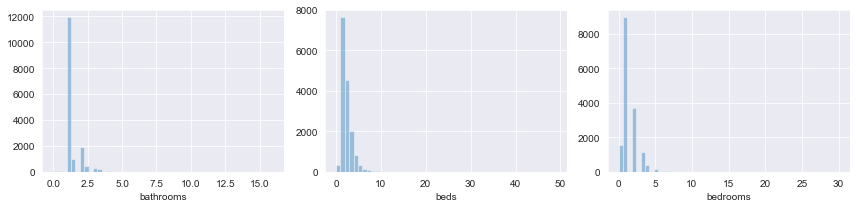

In [35]:
# quantitative variables with small proportion of missing values
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
for (i, col) in enumerate(['bathrooms', 'beds', 'bedrooms']):
    sns.distplot(listings_df[col].dropna(), ax=axs[i], kde=False)
fig.tight_layout()

Each of these variables is highly peaked and highly right skewed, so the imputing them with the mode (instead of mean or median) is a reasonable choice

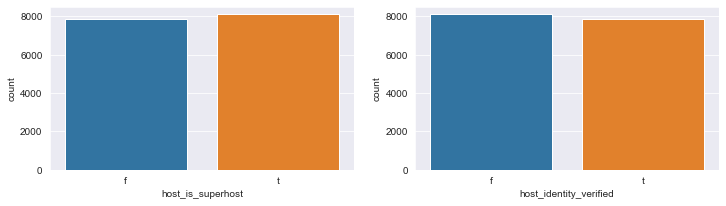

In [36]:
# categorical variables with small proportion of missing values
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
for (i, col) in enumerate(['host_is_superhost', 'host_identity_verified']):
    sns.countplot(listings_df[col].dropna(), ax=axs[i % 2])

These binary variables are fairly evenly distributed, so the imputing them with mode is a reasonable choice.

In [37]:
# dictionary for imputation methods for columns with missing values
impute_vals = defaultdict(None)
# imputation values for some columns
for col in ['bathrooms', 'beds', 'bedrooms', 'host_since',
            'host_is_superhost', 'host_identity_verified']:
    impute_vals[col] = listings_df[col].mode().values[0]

Now let's look at the distributions of `cleaning_fee` and  `security_deposit`

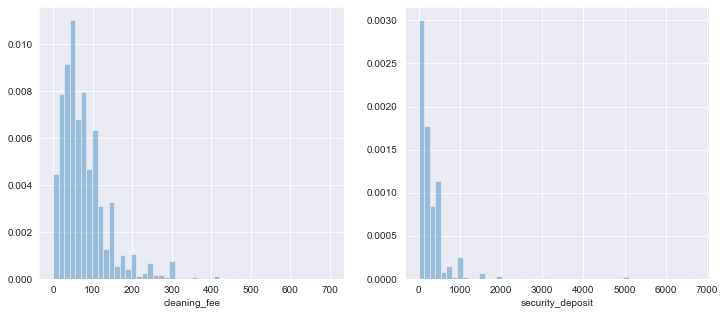

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for (i, col) in enumerate(['cleaning_fee', 'security_deposit']):
    sns.distplot(listings_df[col].dropna(), kde=False, norm_hist=True, ax=axs[i])

Given the large peak around zero for `security_deposit` and the fact that it seems reasonable to assign a value of zero to a listing that doesn't have security deposit information available, we'll use this for our imputation value. We'll use median for `cleaning_fee`, since it's highly peaked and skewed at a non-zero value.

In [39]:
# imputation values for more columns
impute_vals['security_deposit'] = 0
impute_vals['cleaning_fee'] = listings_df['cleaning_fee'].dropna().median()

Finally let's look at the distributions of `host_response_rate` and `host_response_time`

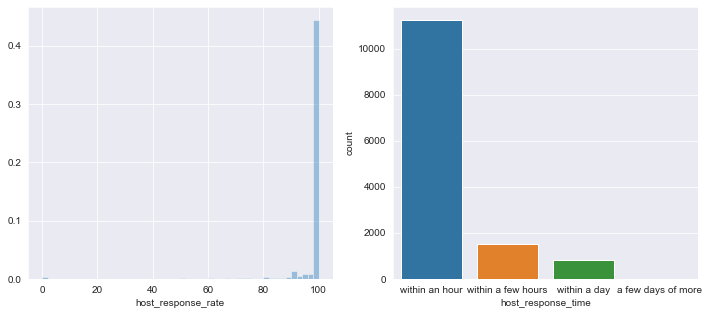

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.distplot(listings_df['host_response_rate'].dropna(), kde=False, norm_hist=True, ax=axs[0])
sns.countplot(listings_df['host_response_time'].dropna(), ax=axs[1])

Given the large skewness and peaks, we'll impute these with mode as well

In [41]:
# last imputation values
for col in ['host_response_rate', 'host_response_time']:
    impute_vals[col] = listings_df[col].mode().values[0]

In [42]:
# impute all missing values
listings_df = listings_df.fillna(impute_vals)

##### Downcast dtypes

In the last section we noted that some float variables could be downcast to ints to speed up computation. We'll do that now.

In [43]:
# downcast to int
listings_df.loc[:, conv_dtypes['int']] = listings_df[conv_dtypes['int']].astype('int') 

Now that we have no missing values, we can also cast some categorical to boolean dtypes

In [44]:
def conv_to_bool(entry):
    """Convert string entries to booleans."""
    return entry == 't'

conv_dtypes['bool'] = {'host_identity_verified', 'host_is_superhost', 
                       'instant_bookable', 'is_business_travel_ready', 
                       'require_guest_phone_verification',
                       'require_guest_profile_picture', 'requires_license'}

# downcast to boolean
listings_df = conv_cols(listings_df, conv_dtypes, conv_to_bool, 'bool') 

#### `calendar` dataset

##### Drop rows/columns

We check for duplicates

In [45]:
num_dups = calendar_df.duplicated().sum()
num_dups

0

Next we'll looks at rows or columns containing a lot of missing values. We'll choose a lower threshold of 25% missing values

In [46]:
# rows with high proportion of missing values in listings df
prop_missing_vals_df(calendar_df, axis=1)

prop_miss_vals
city                            
vancouver 175625        0.285714
          463           0.285714
          461           0.285714
          460           0.285714
          459           0.285714
...                          ...
          197337        0.285714
          197336        0.285714
          197335        0.285714
          197353        0.285714
          197351        0.285714

[1084 rows x 1 columns]

In [47]:
# columns with high proportion of missing values in listings df
prop_missing_vals_df(calendar_df, axis=0)

,prop_miss_vals


No columns are missing >25% of values, but 718 rows are missing about 28.5% of values. We'll look closer at these rows.

In [48]:
# rows missing values
miss_vals_df = calendar_df.loc[calendar_df.isna().sum(axis=1) > 0]
miss_vals_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1084 entries, ('portland', 298877) to ('vancouver', 1856971)
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      1084 non-null   int64  
 1   date            1084 non-null   object 
 2   available       1084 non-null   object 
 3   price           5 non-null      object 
 4   adjusted_price  5 non-null      object 
 5   minimum_nights  1079 non-null   float64
 6   maximum_nights  1079 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 21.1+ MB


All the missing values are present in the `price` and `adjusted_price` columns, and all the missing values are in the same 718 rows.

In [49]:
# indexes of calendar entries with missing values
miss_cal_idx = miss_vals_df.reset_index(level=0)\
               .groupby(['city', 'listing_id'])['listing_id'].count()
miss_cal_idx

city       listing_id
portland   6132497         5
vancouver  906964        178
           5807056       178
           7150429       179
           14237741        8
           27466923      179
           38825501      178
           39093654      179
Name: listing_id, dtype: int64

The missing calendar rows are concentrated in just six listing ids. Four of these listing ids are missing a large number of entries (around half a year of data), we'll drop these from both data sets. 

In [50]:
# drop listing ids with large number of missing entries
listing_ids = {index[1] for index in miss_cal_idx[miss_cal_idx > 7].index}
list_ids_mask = ~ listings_df['id'].apply(lambda x: x in listing_ids)
listings_df = listings_df[list_ids_mask]
cal_ids_mask = ~ calendar_df['listing_id'].apply(lambda x: x in listing_ids)
calendar_df = calendar_df[cal_ids_mask]

We'll also drop `adjusted_price`.This appears to be a variable added by InsideAirBnB, but couldn't find any information about it. Furthermore, we assume `price` in the `calendar` dataset is the equivalent to `price` in `listings`

In [51]:
calendar_df = calendar_df.drop(columns=['adjusted_price'])

##### Enforce dtypes

In [52]:
calendar_df.dtypes

listing_id          int64
date               object
available          object
price              object
minimum_nights    float64
maximum_nights    float64
dtype: object

In [53]:
# set dtypes
calendar_df.loc[:, 'date'] = calendar_df['date'].astype('datetime64')
conv_dtypes = defaultdict(set)
conv_dtypes['bool'] = {'available'}
conv_dtypes['float'] = {'price'}
calendar_df = conv_cols(calendar_df, conv_dtypes, conv_to_bool, 'bool')
calendar_df = conv_cols(calendar_df, conv_dtypes, conv_to_float, 'float')

##### Missing Values

Finally we'll inspect the rows with missing values in `calendar` for the two listings which only had seven missing values

In [54]:
# inspect calendar df for listings missing seven values
listing_ids = [index[1] for index in miss_cal_idx[miss_cal_idx <= 7].index]
cal_id_mask = (calendar_df['listing_id'].apply(lambda x: x in listing_ids) &
               (calendar_df['price'].isna()))
two_listings_df = calendar_df[cal_id_mask]
two_listings_df

,,listing_id,date,available,price,minimum_nights,maximum_nights
city,,,,,,,


These missing values are all in the same week. It makes sense to backfill with prices from the corresponding days on the previous week.

In [55]:
def backfill_missing_prices(calendar_df, two_listings_df):
    """Backfill missing price data for two listings in calendar dataset."""
    week_delta = pd.Timedelta(1, unit='w')
    calendar_df_cp = calendar_df.copy()
    for index in two_listings_df.index:
        listing_id = two_listings_df.loc[index]['listing_id']
        one_week_ago = two_listings_df.loc[index]['date'] - week_delta
        mask = ((calendar_df_cp['listing_id'] == listing_id) & 
               (calendar_df_cp['date'] == one_week_ago))
        price = calendar_df_cp[mask]['price'].values[0]
        calendar_df_cp.loc[index, 'price'] = price
    return calendar_df_cp

calendar_df = backfill_missing_prices(calendar_df, two_listings_df)

In [56]:
# check backfill worked
len(calendar_df[(cal_id_mask) &  calendar_df['price'].isna()])

0

##### Synchronize `date`

The data for Vancouver and Portland was collected earlier than for Seattle, so we'll make sure to sync up dates.

In [57]:
min_date = calendar_df.loc['seattle']['date'].min()
max_date = calendar_df.loc['vancouver']['date'].max()
cal_date_mask = ((calendar_df['date'] >= min_date) & (calendar_df['date'] <= max_date))
calendar_df = calendar_df[cal_date_mask]

### Create amenities features.

There's a lot of potentially useful information in the `amentities` column but it's going to take a little bit of work to get it. Currently the entries in the amenities columns are long strings containing amenities for that listing.

In [58]:
amenities_series = listings_df['amenities']
amenities_series

city           
seattle    0       {Internet,Wifi,Kitchen,"Free parking on premis...
           1       {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
           2       {Internet,Wifi,"Air conditioning",Kitchen,"Fre...
           3       {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
           4       {TV,"Cable TV",Internet,Wifi,"Wheelchair acces...
                                         ...                        
vancouver  6130    {Wifi,Kitchen,"Free street parking",Heating,Wa...
           6145    {TV,Wifi,Kitchen,"Paid parking off premises","...
           6150    {TV,Wifi,"Air conditioning",Pool,Kitchen,Gym,E...
           6152    {TV,"Cable TV",Wifi,Kitchen,"Free parking on p...
           6174    {Wifi,Kitchen,Breakfast,"Free street parking",...
Name: amenities, Length: 15982, dtype: object

To proceed we need to do a bit of processing.

In [59]:
def process_amenities(amenities_series):
    """Process entries in amenities series."""
    # convert amenities lists into sets of strings
    amenities_series = amenities_series.apply(lambda x: set(x.split(',')))
    # set for tracking unique amenities
    amenities_set = set()
    # for dropping all non alphanumeric characters
    regex = re.compile('[^0-9a-zA-Z ]+')
    # function for processing each amenity lists in series entries
    def process_and_add(amenities_set, regex, amens_entry):
        new_amens_entry = set()
        for amen in amens_entry:
            # drop non alpha numeric
            amen = regex.sub('', amen)
            # don't keep track of translation failures
            if 'translation' in amen:
                pass
            else:
                new_amens_entry.add(amen)
                # add to main set if it hasn't been seen
                if amen not in amenities_set:
                    amenities_set.add(amen)
        return new_amens_entry
    # process amenity list entries in series
    apply_func = partial(process_and_add, amenities_set, regex)
    amenities_series = amenities_series.apply(apply_func)

    return amenities_series, amenities_set


def rename_amenities(amenities_series, amenities_set, amenities_mapping):
    """Clean up amenities names."""
    amenities_set = {amen if amen not in amenities_mapping
                     else amenities_mapping[amen] for amen in amenities_set}
    amenities_set = {'amen_' + amen.replace(' ', '_').lower() for amen
                     in amenities_set}

    # function for renaming amenity lists in series entries
    def rename_amens(amenities_mapping, amens_entry):
        new_amens_entry = set()
        for amen in amens_entry:
            try:
                amen = amenities_mapping[amen]
            except KeyError:
                pass
            amen = 'amen_' + amen.replace(' ', '_').lower()
            new_amens_entry.add(amen)
        return new_amens_entry

    # process amenity list entries in series
    apply_func = partial(rename_amens, amenities_mapping)
    amenities_series = amenities_series.apply(apply_func)

    return amenities_series, amenities_set

In [60]:
# get renamed series and set of amenities
amenities_series, amenities_set = process_amenities(
                                      listings_df['amenities'])
amenities_mapping = {' toilet': 'Toilet',
                     '24hour checkin': '24 hour checkin',
                     'Accessibleheight bed': 'Accessible height bed',
                     'Accessibleheight toilet':
                     'Accessible height toilet',
                     'Buzzerwireless intercom': 'Buzzer/Wireless intercom',
                     'Familykid friendly': 'Family/kid friendly',
                     'Highresolution computer monitor':
                     'High resolution computer monitor',
                     'Pack n Playtravel crib': 'Pack-n-Play travel crib',
                     'Roomdarkening shades': 'Room darkening shades',
                     'Self checkin': 'Self check-in',
                     'SkiinSkiout': 'Ski-in/Ski-out',
                     'Stepfree shower': 'Step-free shower',
                     'Washer  Dryer': 'Washer/Dryer',
                     'Welllit path to entrance':
                     'Well-lit path to entrance'}
amenities_series, amenities_set = rename_amenities(amenities_series,
                                                   amenities_set,
                                                   amenities_mapping)

Now we have a series of lists of cleaned up amenity names

In [61]:
amenities_series

city           
seattle    0       {amen_heating, amen_host_greets_you, amen_iron...
           1       {amen_24_hour_checkin, amen_heating, amen_iron...
           2       {amen_dogs, amen_heating, amen_host_greets_you...
           3       {amen_other, amen_heating, amen_toilet_paper, ...
           4       {amen_other, amen_24_hour_checkin, amen_heatin...
                                         ...                        
vancouver  6130    {amen_heating, amen_iron, amen_hot_water, amen...
           6145    {amen_cleaning_before_checkout, amen_heating, ...
           6150    {amen_elevator, amen_heating, amen_gym, amen_i...
           6152    {amen_heating, amen_iron, amen_hot_water, amen...
           6174    {amen_heating, amen_iron, amen_hot_water, amen...
Name: amenities, Length: 15982, dtype: object

And a set of all unique amenities. Let's see how many there are

In [62]:
# count number of unique amenities
len(amenities_set)

191

Let's whittle this number down by taking amenities which are don't have extremely unbalanced distributions. We'll find amenities present in more than 10% but less than 90% of listings.

In [63]:
def count_amenities(amenities_series, amenities_set):
    """Count total occurences of each amenity in dataset."""
    amenities_count = {amen: 0 for amen in amenities_set}

    for amens_entry in amenities_series:
        for amen in amens_entry:
            amenities_count[amen] += 1

    return amenities_count

def get_amenities_cols(amenities_series, amenities_count,
                       prop_low=0.1, prop_hi=0.9):
    """Return amenities with proportion in between thresholds."""
    # dataframe of amenities counts
    n = len(amenities_series)
    amenities_prop_df = pd.DataFrame(amenities_count, index=['prop']).T
    amenities_prop_df = amenities_prop_df.sort_values(by='prop')/n
    amenities_prop_df = amenities_prop_df.query('prop >= ' + str(prop_low))
    amenities_prop_df = amenities_prop_df.query('prop <= ' + str(prop_hi))

    return set(amenities_prop_df.index)

In [64]:
# get amenities present in > 10% and less than 90% of listings
amenities_count = count_amenities(amenities_series, amenities_set)
amenities_cols = get_amenities_cols(amenities_series, amenities_count,
                                    prop_low=0.1, prop_hi=0.9)
# check number of these
len(amenities_cols)

49

That's a more reasonable number of amenities for us to consider. Finally we'll create a dataframe of boolean variables the presence/absence of these amenities for each listing. We'll also include a variable which counts the number of these amenities present for each listing 

In [65]:
def get_amenities_df(amenities_series, amenities_cols):
    """Create dataframe of amenities variables."""
    amenities_df = pd.DataFrame(columns=amenities_cols,
                                index=amenities_series.index).astype('bool')

    def has_amenity(amenity, amens_entry):
        return amenity in amens_entry

    for amenity in amenities_cols:
        applyfunc = partial(has_amenity, amenity)
        amenities_df.loc[:, amenity] = amenities_series.apply(applyfunc)

    def num_amenities(amenities_cols, amen_entry):
        return len(set(amen_entry).intersection(amenities_cols))

    applyfunc = partial(num_amenities, amenities_cols)
    amenities_df['num_amenities'] = amenities_series.apply(applyfunc)

    return amenities_df

In [66]:
# dataframe with amenities as boolean columns
amenities_df = get_amenities_df(amenities_series, amenities_cols)
amenities_df

amen_elevator  amen_24_hour_checkin  amen_gym  amen_iron  \
city                                                                       
seattle   0             False                 False     False       True   
          1             False                  True     False       True   
          2             False                 False     False       True   
          3             False                 False     False       True   
          4             False                  True     False       True   
...                       ...                   ...       ...        ...   
vancouver 6130          False                 False     False       True   
          6145          False                 False     False      False   
          6150           True                 False      True       True   
          6152          False                 False     False       True   
          6174          False                 False     False       True   

                amen_hot_water  amen_air_conditioning  amen_internet  \
city                                                                   
seattle   0               True                  False           True   
          1              False                   True           True   
          2               True                   True           True   
          3              False                   True          False   
          4               True                  False           True   
...                        ...                    ...            ...   
vancouver 6130            True                  False          False   
          6145            True                  False          False   
          6150            True                   True          False   
          6152            True                  False          False   
          6174            True                  False          False   

                amen_hair_dryer  amen_pets_allowed  \
city                                                 
seattle   0                True               True   
          1                True              False   
          2                True              False   
          3                True              False   
          4                True               True   
...                         ...                ...   
vancouver 6130             True              False   
          6145            False              False   
          6150             True              False   
          6152             True              False   
          6174             True              False   

                amen_dishes_and_silverware  amen_carbon_monoxide_detector  \
city                                                                        
seattle   0                           True                           True   
          1                          False                           True   
          2                           True                          False   
          3                           True                           True   
          4                           True                           True   
...                                    ...                            ...   
vancouver 6130                        True                           True   
          6145                       False                           True   
          6150                        True                           True   
          6152                        True                           True   
          6174                       False                           True   

                amen_patio_or_balcony  amen_bathtub  \
city                                                  
seattle   0                      True         False   
          1                     False         False   
          2                     False         False   
          3                      True         False   
          4                      True         False   


And finally, we'll add this to our listings dataframe

In [67]:
# add amenities to listings df
listings_df = pd.concat([listings_df, amenities_df], axis=1)\
              .drop(columns=['amenities'])

### Currency conversion

The Vancouver prices are expressed in CAD, so we'll convert to USD. The exchange rate as of November 26, 2019 was 1 CAD = 0.75341 USD.

In [68]:
def conv_cad_to_usd(entry):
    """Currency conversion helper."""
    return round(0.76124 * entry, 0)

def conv_curr_cols(df, curr_cols, curr_conv_func):
    """Convert currency columns."""
    df_cp = df.copy()
    df_cp.loc[:, curr_cols] = \
        df_cp[curr_cols].apply(lambda x: conv_cad_to_usd(x) 
                               if 'vancouver' in x.name else x, axis=1)
    return df_cp

In [69]:
# convert currency columns in listings df
list_curr_cols = ['cleaning_fee', 'price', 'security_deposit']
listings_df = conv_curr_cols(listings_df, list_curr_cols, conv_cad_to_usd)

In [70]:
# workaround for converting calendar columns due to slowness of conv_curr_cols
cal_van_price = calendar_df.loc['vancouver']['price'].apply(conv_cad_to_usd).values
cal_other_price = calendar_df.loc[['seattle', 'portland']]['price'].values
calendar_df.loc[:, 'price'] = np.append(cal_other_price, cal_van_price)

### Save cleaned datasets

In [71]:
# save dfs as h5 files to save write time
listings_df = alphabetize_cols(listings_df)
listings_df.to_hdf('data/listings.h5', key='listings', mode='w', format='table')
calendar_df = alphabetize_cols(calendar_df, first_col='listing_id')
calendar_df.to_hdf('data/calendar.h5', key='calendar', mode='w', format='table')

In [80]:
# delete unwanted dataset
datadir = './data'
for item in os.listdir(datadir):
    if item.endswith('csv'):
        os.remove(os.path.join(datadir, item))